# allelic heterogeneity histograms

In [20]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import pickle

import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
from joblib import Parallel, delayed
import os

def load_model(gene, decompress=True, rel='../'):
    p = gene2path.get(gene)
    m = pickle.load(open(rel + p, 'rb'))
    if decompress:
        m._decompress_model()
    return m

def load_active(gene, rel='../'):
    p = gene2path.get(gene)
    m = pickle.load(open(rel + p, 'rb'))
    df = pd.DataFrame(m.active, index=m.study_ids)
    return df

model_paths = np.loadtxt('../output/requests/GTEx_cafeh_genotype_ss.txt', dtype=str)
vr_paths = np.loadtxt('../output/requests/GTEx_cafeh_genotype_ss_variant_reports.txt', dtype=str)
gene2path = {p.split('/')[3]: p for p in model_paths} 

### Allelic heterogeneity histograms

In [21]:
def generate_coloc_table2(gene):
    m = load_model(gene, decompress=False)
    coloc_table = pd.DataFrame(m.active, index=m.study_ids).reset_index().melt(id_vars='index')
    coloc_table.loc[:, 'gene'] = gene
    coloc_table.rename(columns={'index': 'tissue', 'variable': 'component'}, inplace=True)
    return(coloc_table)

In [22]:
if not os.path.isfile('component_coloc.pkl'):
    for gene in tqdm(list(gene2path.keys())):
        try:
            d = generte_coloc_table2(gene)
            component_coloc.append(d)
        except Exception as e:
            print(gene)
    pickle.dump(component_coloc, open('component_coloc.pkl', 'wb'))

component_coloc = pickle.load(open('component_coloc.pkl', 'rb'))

In [23]:
components_per_tissue = {}
for d in tqdm(component_coloc):
    try:
        gene = d.iloc[0].gene
        components_per_tissue[gene] = \
            d.groupby('tissue').value.apply(lambda x: (x > 0.5).sum())
    except Exception as e:
        continue

100%|██████████| 17985/17985 [08:05<00:00, 37.01it/s]


Text(0.5, 0, 'Components')

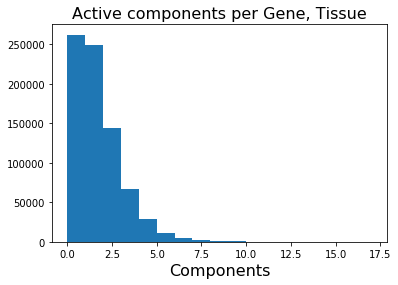

In [51]:
cpt = pd.concat(components_per_tissue)

plt.hist(cpt, bins=17)
plt.title('Active components per Gene, Tissue', size=16)
plt.xlabel('Components', size=16)

In [13]:
import pandas as pd
import glob
from tqdm import tqdm

paths = glob.glob('/work-zfs/abattle4/lab_data/GTEx_v8/ciseQTL/GTEx_Analysis_v8_eQTL/*.signif_variant_gene_pairs.txt')

In [14]:
tissue2genes = {
    p.split('/')[-1].split('.')[0]: pd.read_csv(p, sep='\t', usecols=[1]).gene_id.values for p in tqdm(paths)}

100%|██████████| 49/49 [00:55<00:00,  1.13s/it]


In [34]:
t = 'Adipose_Visceral_Omentum'

In [36]:
A = cpt.reset_index()
eqtls = [A[(A.tissue == t) & A.level_0.isin(tissue2genes[t])] for t in tqdm(tissue2genes)]

In [39]:
cpt_eqtl = pd.concat(eqtls)

In [44]:
np.bincount(cpt_eqtl.value)

array([ 21506, 102816,  92856,  53026,  25025,  10768,   4669,   2085,
         1041,    566,    312,    212,    126,     80,     48,     19,
           10,      5])

In [46]:
np.bincount(cpt_eqtl.value)[2:].sum()

190848

In [48]:
p

'/work-zfs/abattle4/lab_data/GTEx_v8/ciseQTL/GTEx_Analysis_v8_eQTL/Adipose_Visceral_Omentum.v8.signif_variant_gene_pairs.txt'

Text(0.5, 0, 'Components')

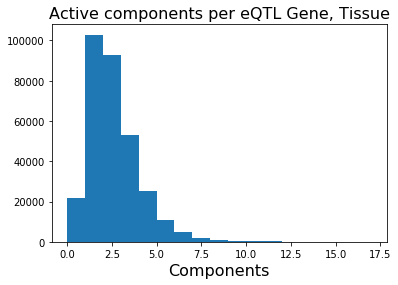

In [50]:
plt.hist(cpt_eqtl.value, bins=17)
plt.title('Active components per eQTL Gene, Tissue', size=16)
plt.xlabel('Components', size=16)

100%|██████████| 17985/17985 [00:25<00:00, 701.44it/s]


Text(0.5, 0, 'Components')

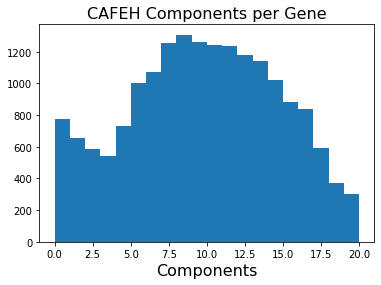

In [8]:
components_per_gene = {}
for d in tqdm(component_coloc):
    try:
        gene = d.iloc[0].gene
        components_per_gene[gene] = d[d.value > 0.5].component.unique().size
    except Exception as e:
        continue

plt.hist(pd.Series(components_per_gene), bins=20)
plt.title('CAFEH Components per Gene', size=16)
plt.xlabel('Components', size=16)

In [9]:
all_tissue_genes = [p for p in component_coloc if p.shape[0]==(49*20)]

In [10]:
all_tissue_genes = [p.pivot('tissue', 'component', 'value') for p in tqdm(all_tissue_genes)]

100%|██████████| 12294/12294 [00:42<00:00, 290.97it/s]


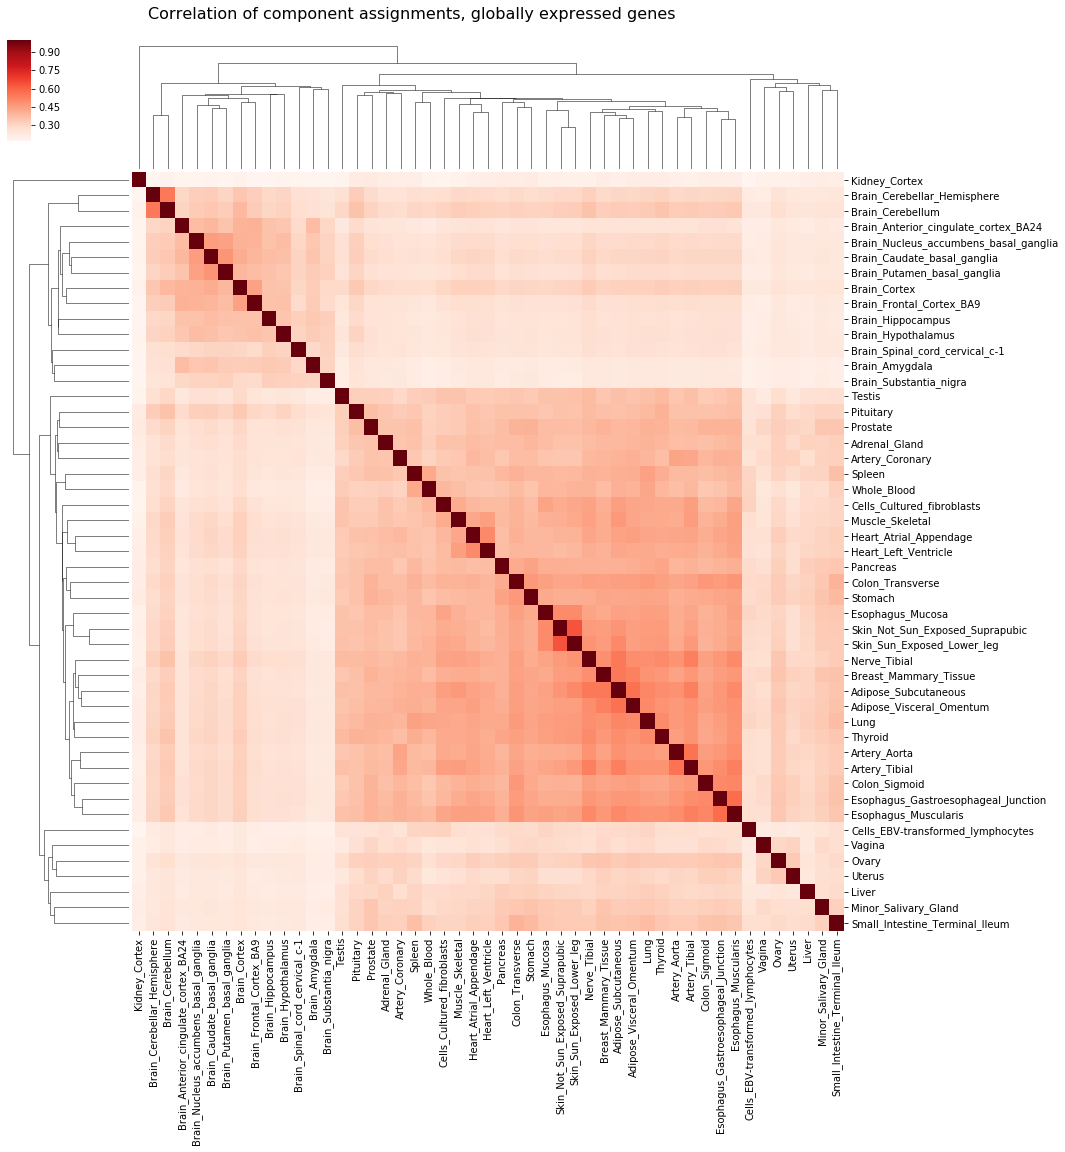

In [13]:
A = pd.concat(all_tissue_genes, axis=1)
W = pd.DataFrame(np.corrcoef(A.values), index=A.index.values, columns=A.index.values)
cg = sns.clustermap(W, figsize=(15, 15), cmap='Reds')

#cg.ax_row_dendrogram.set_visible(False)
#cg.ax_col_dendrogram.set_visible(False)
#cg.ax_heatmap.set_yticklabels([])
cg.fig.suptitle('Correlation of component assignments, globally expressed genes', size=16) 
cg.fig.subplots_adjust(top=0.95)